<a href="https://colab.research.google.com/github/RoloNatt/Racoon-Detection/blob/main/racoon_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
postion=pd.read_csv('train_labels_.csv')

In [ ]:
postion.head()

filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127

In [ ]:
postion.shape

(173, 8)

In [ ]:
#loading data and resize it and collect it in one folder

trainpath = 'Racoon/images/'
new_size=128
X_train = []
y_train = []


for path in tqdm.tqdm(postion['filename'].values[:161]):
    orignal_image = cv2.imread(trainpath+path)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image , (new_size,new_size))
    X_train.append(resized_image)
print('image reading ...finished')
print('--------------------------------------------------')


100%|██████████| 161/161 [00:01<00:00, 148.25it/s]

image reading ...finished
--------------------------------------------------


In [ ]:
X_train=np.array(X_train)

In [ ]:
X_train = X_train / 255.0

In [ ]:
X_train.shape

(161, 128, 128, 3)

In [ ]:
img=plt.imread('Racoon Images/images/raccoon-17.jpg')

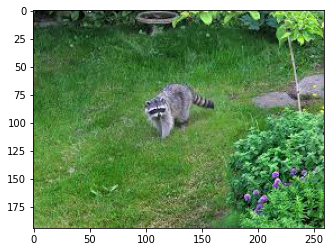

In [ ]:
plt.imshow(img)

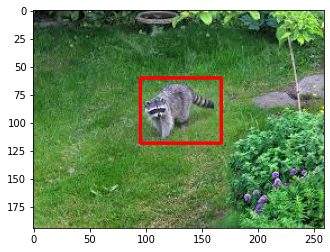

In [ ]:
index = 0
img=cv2.rectangle(img,
                  (postion['xmin'][index],postion['ymin'][index]),
                  (postion['xmax'][index],postion['ymax'][index]),
                  (255,0,0),2)
plt.imshow(img)

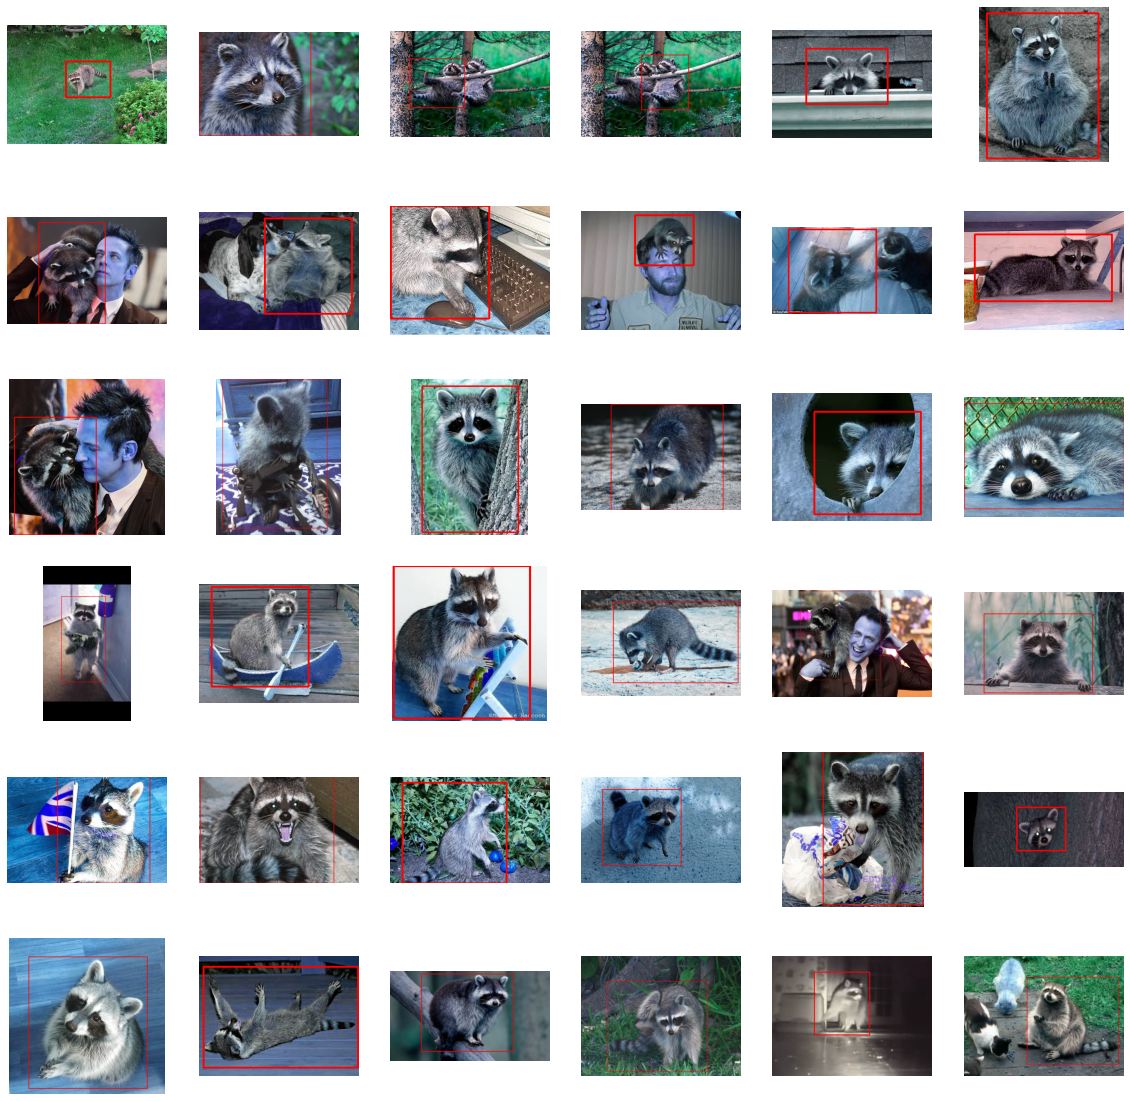

In [ ]:
#showing training images with labels
plt.figure(figsize=(20,20))
for n , i in enumerate(range(36)) :
    plt.subplot(6,6,n+1)
    img = cv2.imread(trainpath+str(postion.iloc[i,0]))
    img=cv2.rectangle(img,(postion['xmin'][i],postion['ymin'][i]), (postion['xmax'][i],postion['ymax'][i]) , (255,0,0),2)
    plt.imshow(img)
    plt.axis('off')



In [ ]:
#loading data and resize it and collect it in one folder

testpath = 'Racoon Images/images/'
new_size=128
X_test = []
y_test = []

for path in tqdm.tqdm(postion['filename'].values[161:]):
    orignal_image = cv2.imread(testpath+path)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image , (new_size,new_size))
    X_test.append(resized_image)

X_test = np.array(X_test)
X_test = X_test / 255.0
print('image reading ...finished')

100%|██████████| 12/12 [00:00<00:00, 188.75it/s]

image reading ...finished


In [ ]:
postion=postion[["width","height","xmin","ymin","xmax","ymax"]]

postion["xmin"] = postion["xmin"] *new_size/postion["width"]
postion["xmax"] = postion["xmax"]*new_size /postion["width"]
postion["ymin"] = postion["ymin"] *new_size/postion["height"]
postion["ymax"] = postion["ymax"] *new_size/postion["height"]

In [ ]:
#postion=postion.astype('int32')
postion.drop(['width','height'],axis=1,inplace=True)
postion.head()

xmin       ymin       xmax        ymax
0  46.949807  39.587629  82.532819   77.855670
1   0.581818   0.296296  89.406061  127.703704
2  15.786667  34.240000  59.733333   92.800000
3  48.426667  29.760000  85.973333   95.360000
4  27.194139  22.832432  92.366300   87.870270

In [ ]:
y_train=postion.iloc[:161,:]
y_test=postion.iloc[161:,:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

![image.png](attachment:b19fc442-2f73-4e13-8848-af61f620efc7.png)

In [ ]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [ ]:
#callbacks
EarlyStop=EarlyStopping(patience=5,monitor='val_iou',restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_iou',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_iou',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

#optimizer
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [ ]:
model=Sequential([
                    Conv2D(64,3,activation='relu',kernel_initializer='he_normal',input_shape=(new_size,new_size,3),kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),

                    Conv2D(128,3,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),

                    Conv2D(256,3,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    MaxPooling2D(3),


                    Flatten(),
                    Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(4,activation='relu',kernel_initializer='glorot_normal')

])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       2

In [ ]:
model.compile(optimizer=optimizer_adam, loss='mse', metrics=[IoU])

history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=4,
                  steps_per_epoch=len(X_train)//4,
                  callbacks=callback, verbose=1)

Epoch 1/200
40/40 [==============================] - 4s 25ms/step - loss: 1390.3259 - IoU: 0.3449 - val_loss: 3110.3308 - val_IoU: 0.0488
Epoch 2/200
40/40 [==============================] - 1s 19ms/step - loss: 595.0505 - IoU: 0.4618 - val_loss: 3389.7766 - val_IoU: 0.0594
Epoch 3/200
40/40 [==============================] - 1s 27ms/step - loss: 512.0408 - IoU: 0.4687 - val_loss: 2455.9958 - val_IoU: 0.0729
Epoch 4/200
40/40 [==============================] - 1s 25ms/step - loss: 553.7479 - IoU: 0.4583 - val_loss: 1456.3287 - val_IoU: 0.1581
Epoch 5/200
40/40 [==============================] - 1s 21ms/step - loss: 553.0658 - IoU: 0.4622 - val_loss: 1155.5840 - val_IoU: 0.2131
Epoch 6/200
40/40 [==============================] - 1s 21ms/step - loss: 522.0554 - IoU: 0.4763 - val_loss: 812.4590 - val_IoU: 0.3137
Epoch 7/200
40/40 [==============================] - 1s 21ms/step - loss: 577.6913 - IoU: 0.4552 - val_loss: 969.2668 - val_IoU: 0.2564
Epoch 8/200
40/40 [=======================

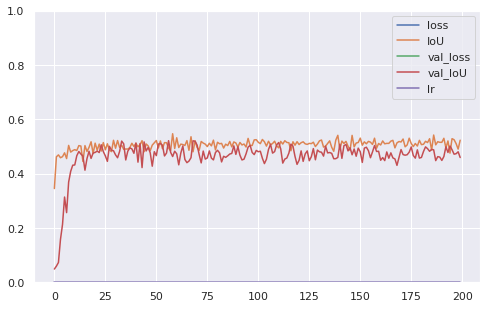

In [ ]:
#plotting training values
import seaborn as sns
sns.set()


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

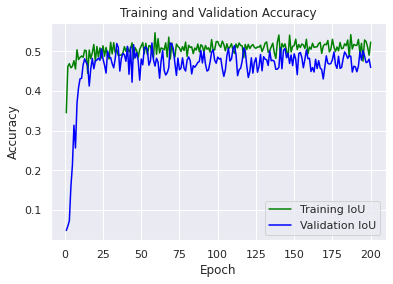

In [ ]:

IoU = history.history['IoU']
val_IoU = history.history['val_IoU']
epochs = range(1, len(IoU) + 1)

#accuracy plot
plt.plot(epochs, IoU, color='green', label='Training IoU')
plt.plot(epochs, val_IoU, color='blue', label='Validation IoU')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
img=plt.imread('Racoon Images/images/raccoon-2.jpg')

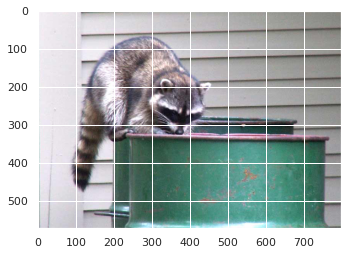

In [ ]:
plt.imshow(img)

In [ ]:
image_height, image_width, _ = img.shape
image = cv2.resize(img,(new_size,new_size))
image = image / 255.0

In [ ]:
image.shape

(128, 128, 3)

In [ ]:
image=np.expand_dims(image,axis=0)

In [ ]:
region = model.predict(image)[0]

In [ ]:
region

array([  0.     ,   0.     ,  70.83912, 107.37472], dtype=float32)

In [ ]:
x0 = int(region[0] * image_width / new_size)
y0 = int(region[1] * image_height / new_size)
x1 = int((region[2]) * image_width / new_size)
y1 = int((region[3]) * image_height / new_size)

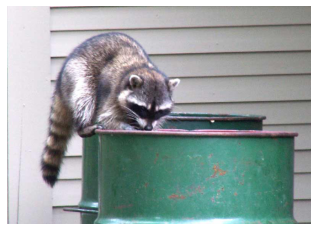

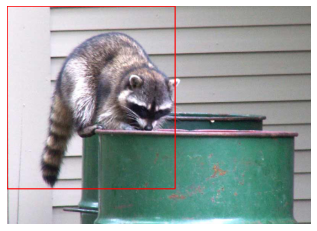

In [ ]:
# Display the image
img=plt.imread('Racoon Images/images/raccoon-2.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()
# Create a Rectangle patch
cv2.rectangle(img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)

# Add the patch to the Axes
plt.imshow(img)
plt.axis('off')
plt.show()

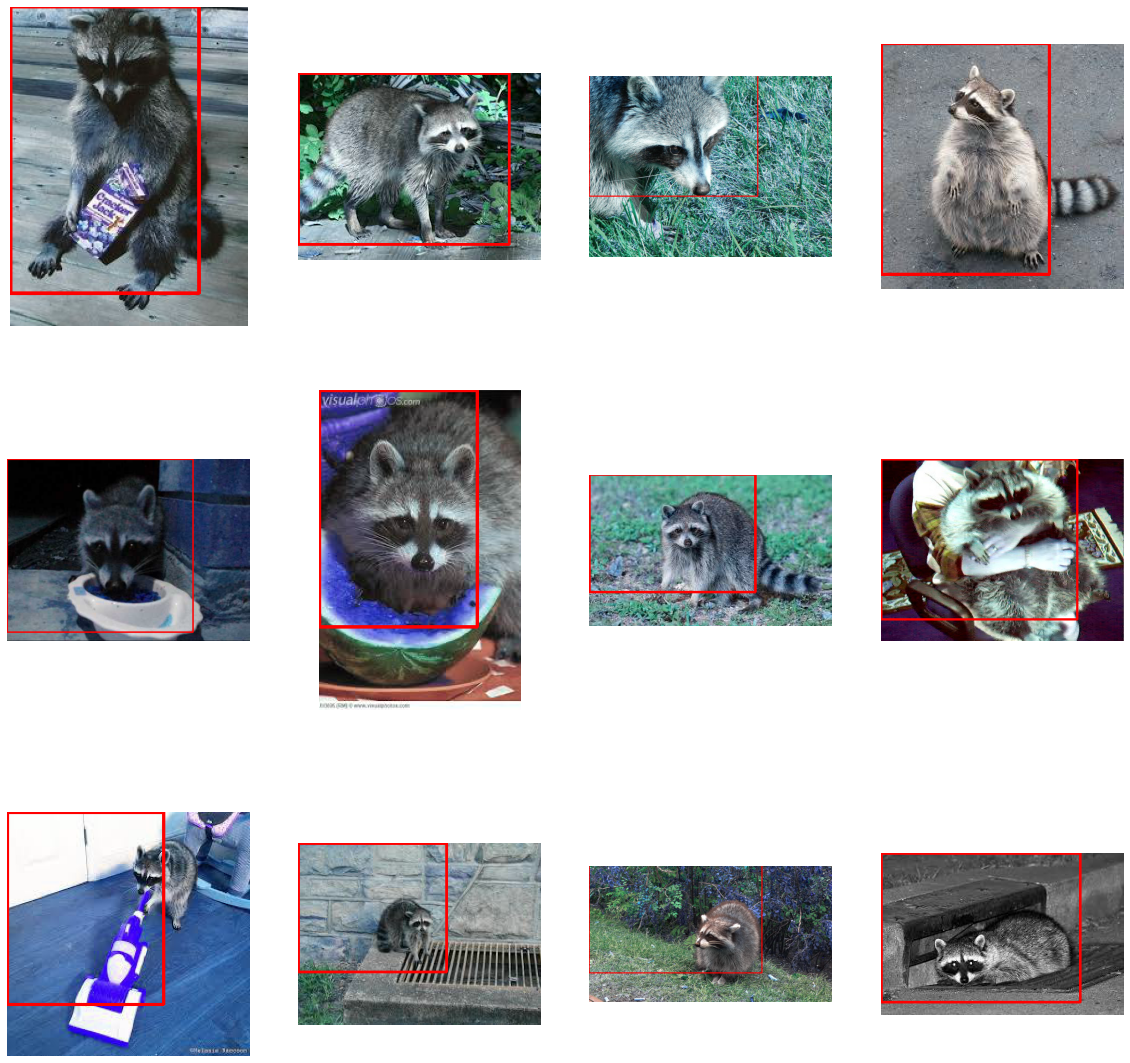

In [ ]:
#showing training images with labels
df=pd.read_csv('train_labels_.csv')[161:]
plt.figure(figsize=(20,20))
for n , i in enumerate(range(12)) :
    plt.subplot(3,4,n+1)

    img = cv2.imread(trainpath+str(df.iloc[i,0]))
    org_img=img.copy()

    image_height, image_width, _ = img.shape


    img = cv2.resize(img,(new_size,new_size))
    img = img / 255.0
    img=np.expand_dims(img,axis=0)
    region = model.predict(img)[0]

    x0 = int(region[0] * image_width / new_size)
    y0 = int(region[1] * image_height / new_size)
    x1 = int((region[2]) * image_width / new_size)
    y1 = int((region[3]) * image_height / new_size)

    cv2.rectangle(org_img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)
    plt.imshow(org_img)
    plt.axis('off')



In [ ]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [ ]:
#callbacks
EarlyStop=EarlyStopping(patience=5,monitor='val_iou',restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_iou',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_iou',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

#optimizer
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
MB=MobileNet(include_top=False,input_shape=(128,128,3))
MB.trainable=True

In [ ]:
model1=Sequential([
                    MB,


                    Flatten(),
                    Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dense(4,activation='relu',kernel_initializer='glorot_normal')

])
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)
model1.compile(optimizer=optimizer_adam, loss='mse', metrics=[IoU])



In [ ]:
history1=model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=4,
                  steps_per_epoch=len(X_train)//4,
                  callbacks=callback, verbose=1)

Epoch 1/200
40/40 [==============================] - 4s 37ms/step - loss: 1245.6763 - IoU: 0.3819 - val_loss: 4793.1899 - val_IoU: 0.1871
Epoch 2/200
40/40 [==============================] - 1s 26ms/step - loss: 433.7942 - IoU: 0.5322 - val_loss: 1127.5416 - val_IoU: 0.4087
Epoch 3/200
40/40 [==============================] - 1s 28ms/step - loss: 332.1393 - IoU: 0.5804 - val_loss: 850.3231 - val_IoU: 0.3856
Epoch 4/200
40/40 [==============================] - 1s 26ms/step - loss: 270.4386 - IoU: 0.5993 - val_loss: 330.5468 - val_IoU: 0.6228
Epoch 5/200
40/40 [==============================] - 1s 26ms/step - loss: 189.8764 - IoU: 0.6516 - val_loss: 959.0695 - val_IoU: 0.3675
Epoch 6/200
40/40 [==============================] - 1s 26ms/step - loss: 191.8021 - IoU: 0.6265 - val_loss: 225.2550 - val_IoU: 0.6176
Epoch 7/200
40/40 [==============================] - 1s 26ms/step - loss: 176.6878 - IoU: 0.6357 - val_loss: 138.2851 - val_IoU: 0.6769
Epoch 8/200
40/40 [==========================

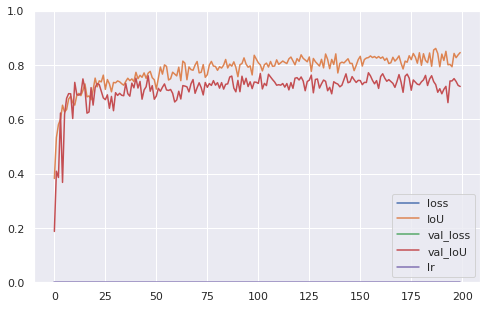

In [ ]:
#plotting training values
import seaborn as sns
sns.set()


pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

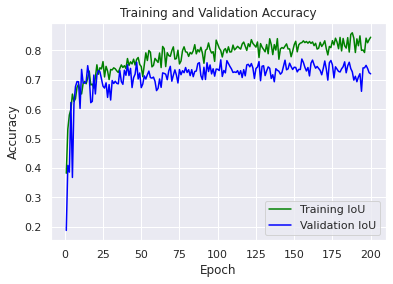

In [ ]:

IoU = history1.history['IoU']
val_IoU = history1.history['val_IoU']
epochs = range(1, len(IoU) + 1)

#accuracy plot
plt.plot(epochs, IoU, color='green', label='Training IoU')
plt.plot(epochs, val_IoU, color='blue', label='Validation IoU')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


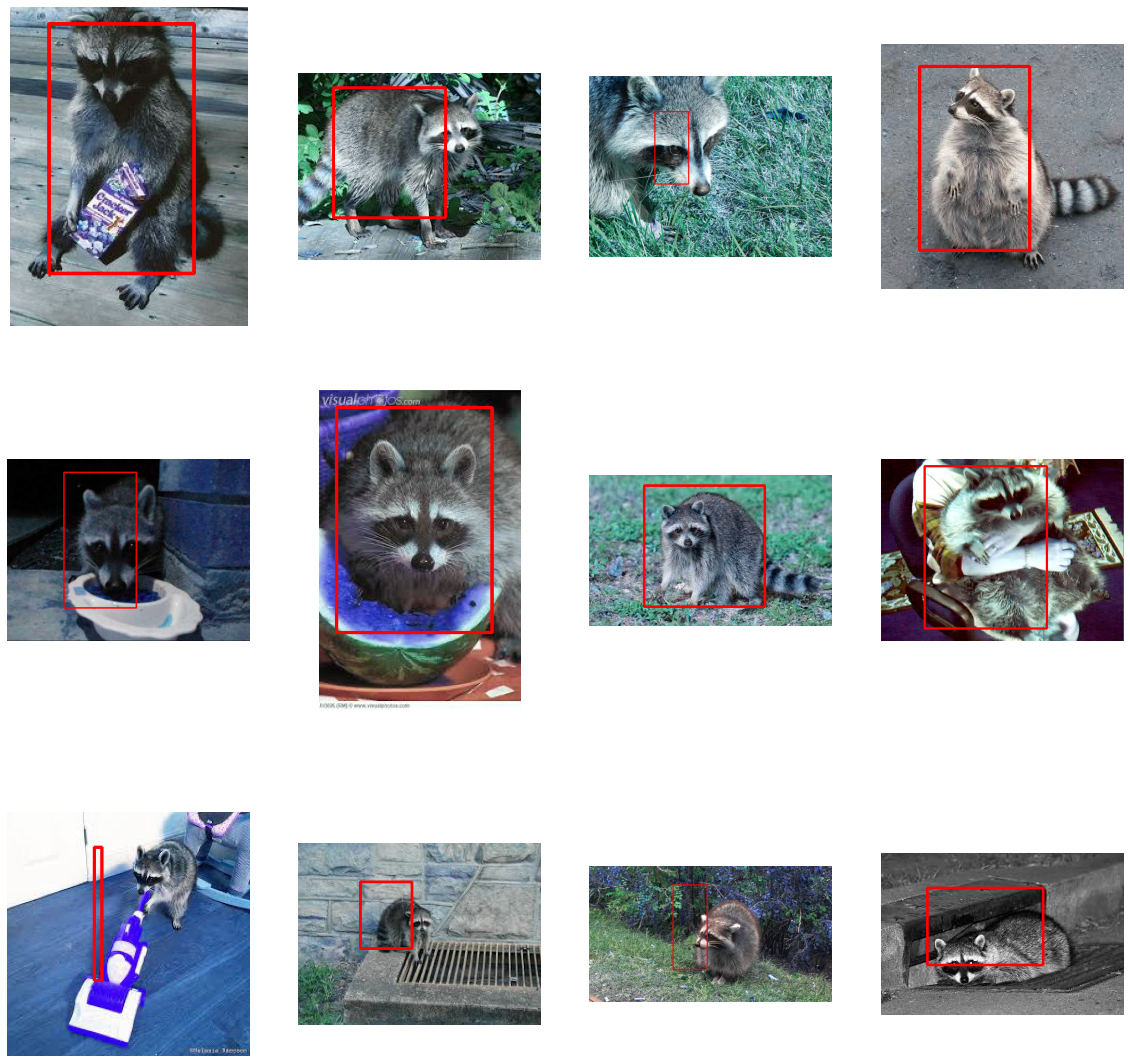

In [ ]:
#showing training images with labels
df=pd.read_csv('train_labels_.csv')[161:]
plt.figure(figsize=(20,20))
for n , i in enumerate(range(12)) :
    plt.subplot(3,4,n+1)

    img = cv2.imread(trainpath+str(df.iloc[i,0]))
    org_img=img.copy()

    image_height, image_width, _ = img.shape


    img = cv2.resize(img,(new_size,new_size))
    img = img / 255.0
    img=np.expand_dims(img,axis=0)
    region = model1.predict(img)[0]

    x0 = int(region[0] * image_width / new_size)
    y0 = int(region[1] * image_height / new_size)
    x1 = int((region[2]) * image_width / new_size)
    y1 = int((region[3]) * image_height / new_size)

    cv2.rectangle(org_img,(x0, y0), ((x1 - x0) , (y1 - y0)) , (255,0,0),2)
    plt.imshow(org_img)
    plt.axis('off')

